# Frequency Feature Masking (FFM) augmentation  
**Introduction**
  
FFM data augmentation is a technique that can be used to improve the performance of machine learning models on audio classification tasks. It works by randomly masking frequency bands in the input data. This can help to train the model to be more robust to noise and variations in the audio signal.  

In the FFM augmentation, the following three methods are used in combination: “low-frequency (LF) masking”, “high- frequency (HF) masking”, and “random frequency band (RF) masking".  

| Aug ID | Mixup | LF | HF | RF |
|---|---|---|---|---|
| 1 | ✓ | ✓ |  |  |
| 2 | ✓ |  | ✓ |  |
| 3 | ✓ |  |  | ✓ |
| 4 | ✓ | ✓ | ✓ |  |
| 5 | ✓ | ✓ |  | ✓ |
| 6 | ✓ |  | ✓ | ✓ |
| 7 | ✓ | ✓ | ✓ | ✓ |

* ✓: Data augmentation technique used
* LF: Low-frequency masking
* HF: High-frequency masking
* RF: Random frequency masking

**Table 1. Augmentation ID allocation based on FFM combinations**

This table shows the data augmentation techniques used for each Aug ID. ✓ indicates that the technique is used, and a blank space indicates that the technique is not used.



# FFM Data Augmentation Technique Implementation in Python

**Implementation**

The following code implements the FFM data augmentation technique in Python using TensorFlow.


## Load library

In [128]:
import librosa
import datetime
import tensorflow as tf
import numpy as np
import os
import pickle

from utils.DataLoader import data_loader
from utils.Generator0 import DataGenerator, feature_extract_cqt, evalEER,  evalScore, evalEER_f, evalEER_f2, gen_fname
from models.models import get_ResMax, get_LCNN, get_BCResMax, get_DDWSseq, get_ofd_model, sigmoidal_decay 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import add,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, maximum, DepthwiseConv2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Convolution2D, GlobalAveragePooling2D, MaxPool2D, ZeroPadding2D
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu, softmax, swish
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint



# use gpu to train
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[5], 'GPU')
    except RuntimeError as e:
        print(e)


# change with your paths if different.        
add2022 = '/Data/data/ADD2022/'
asv2019 = '/Data/data/ASV2019/'

pathset = { 'add2022' : add2022 , 'asv2019':asv2019}
dl = data_loader(pathset)

# pick data (1: ADD, 2: LA)
datapick = '1' 

dl.get_data(data_pick = datapick, tde_pick = 't', to = 't')
dl.get_data(data_pick = datapick, tde_pick = 'd', to = 'd')
dl.get_data(data_pick = datapick, tde_pick = 'e', to = 'e')


## Hyperparameters  
* FFM augmentation technique's **Aug ID 7** application:  
    * `Aug ID 7: Mixup + LF + HF + RF`

In [129]:
# feature:
fmin = 5                                        # minimum frequency (Hz)
hop_length = 128                                # hop length
sr = 16000                                      # sampling rate
sec = 9.0                                       # adjusted seconds of the sample. 
feature = "cqt"                                 # feature to be extracted
filter_scale = 1                                # filter scale factor. Small values (<1) use shorter windows for improved time resolution.
n_bins = 100                                    # number of frequency bins, starting at fmin 


# training:
batch_size = 16                                 # batch size
epoch = 70                                      # number of epochs to run
dropout_rate = 0.5                              # dropout rate
human_weight = 5.0                              # assigning weights to classes
tmp_string = "tmp"                              # used to store intermediate results.


# data augmentations:
beta_param = 0.8                                # mixup application rate
ru = 0.2                                        
uv = [ru, 1-ru]                                 # determines the sample ratio to apply masking based on the uv value.
lowpass = [uv, [7,8,9,10,11,12]]                # low frequency masking hyperparameters 
highpass = [uv, [80,81,82,83,84,85,86,87] ]     # high frequency masking hyperparameters
ranfilter2 = [uv, 2, [8,9,10,11,12]]            # random frequency masking hyperparameters

# ex) hyperparameters for random frequency masking
# ranfilter2 = [uv, raniter, ranf]
    # raniter: the number of times to apply masking for each sample
    # ranf: the frequency bands to mask

## DataGenerator

In [148]:
# params dictionary: A collection of training parameters. Includes the settings required for model training.
params = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': int(n_bins),
          'tofile': tmp_string,
          'shuffle': True,
          'beta_param': beta_param,
          'data_dir': add2022,
          'lowpass': lowpass,
          'highpass': highpass,
          'ranfilter2' : ranfilter2 

}

# params_no_shuffle dictionary: A copy of params with the shuffle parameter set to False. Training without shuffling data.
params_no_shuffle = {'sr': sr,
                     'batch_size': batch_size,
                     'feature': feature,
                     'n_classes': 2,
                     'sec': sec,
                     'filter_scale': filter_scale,
                     'fmin' : fmin,
                     'n_bins': int(n_bins),
                     'tofile': tmp_string,
                     'shuffle': False,
                     'data_dir': add2022
}

# An object created from the DataGenerator class. Handles the processing of training data, such as loading, augmentation, and batch preparation.
training_generator = DataGenerator(dl.train, dl.labels, **params)
# validation_generator = DataGenerator(dl.dev, dl.labels, **params_no_shuffle)
# eval_generator = DataGenerator(dl.eval, dl.labels, **params_no_shuffle)


cqt
Input_shape:(100,282,1)


## FFM Augmentation ID 7: Spectrogram visualization

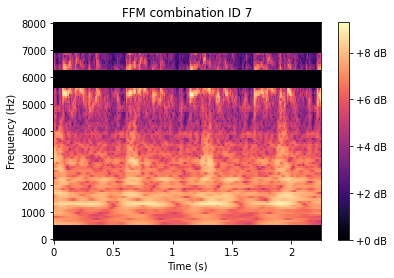

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[54][0][2][:,:,0], y_axis = "linear", sr = sr, 
                               hop_length =hop_length, x_axis='time', ax=ax, auto_aspect=False)


fig.colorbar(img, ax=ax, format="%+2.f dB")


plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title("FFM combination ID 7");
# plt.savefig(save_path + "FFM_all_1.png", dpi=300);


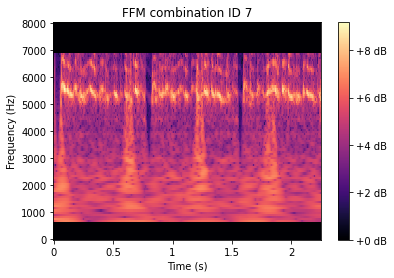

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[12][0][2][:,:,0], y_axis = "linear", sr = sr, 
                               hop_length =hop_length, x_axis='time', ax=ax, auto_aspect=False)


fig.colorbar(img, ax=ax, format="%+2.f dB")


plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title("FFM combination ID 7");
